## CML logistic sanity checks
These cells preview the updated generator (minimum lattice size 20, cropped to requested M) before running the PBS array.

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.generate import generate_cml_logistic
from src.plot_style import apply_plot_style

apply_plot_style()
sns.set_style('white')

def preview_cml_grid(Ms, deltas, T=400, seed=0, **params):
    """
    Generates a grid of CML plots.
    Rows = different M values.
    Columns = different delta values.
    """
    n_rows = len(Ms)
    n_cols = len(deltas)
    
    # Create grid, squeeze=False ensures axes is always 2D array [row, col]
    fig, axes = plt.subplots(
        n_rows, n_cols, 
        figsize=(4 * n_cols, 2.5 * n_rows), 
        squeeze=False,
        sharex='col', # Share time axis per column
        constrained_layout=True
    )

    results = {}

    for i, M in enumerate(Ms):
        for j, d in enumerate(deltas):
            ax = axes[i, j]
            
            # Generate specific instance
            # Note: Explicitly passing delta here overrides any delta in **params
            data = generate_cml_logistic(
                M=M, T=T, delta=d, 
                rng=np.random.default_rng(seed), 
                **params
            )
            
            # Store for return
            results[(M, d)] = data

            # Plot
            im = ax.pcolormesh(
                data.T,
                cmap=sns.color_palette('icefire', as_cmap=True),
                vmin=-2, vmax=2
            )
            
            # Surgical Labeling
            if i == 0:
                ax.set_title(f"$\delta={d}$", fontsize=12, fontweight='bold')
            if j == 0:
                ax.set_ylabel(f"$M={M}$", fontsize=12, fontweight='bold')
            
            # Remove inner ticks for cleanliness
            if i < n_rows - 1:
                ax.tick_params(labelbottom=False)
            if j > 0:
                ax.tick_params(labelleft=False)

    # Common label
    fig.supxlabel("Time Steps")
    plt.show()
    return results

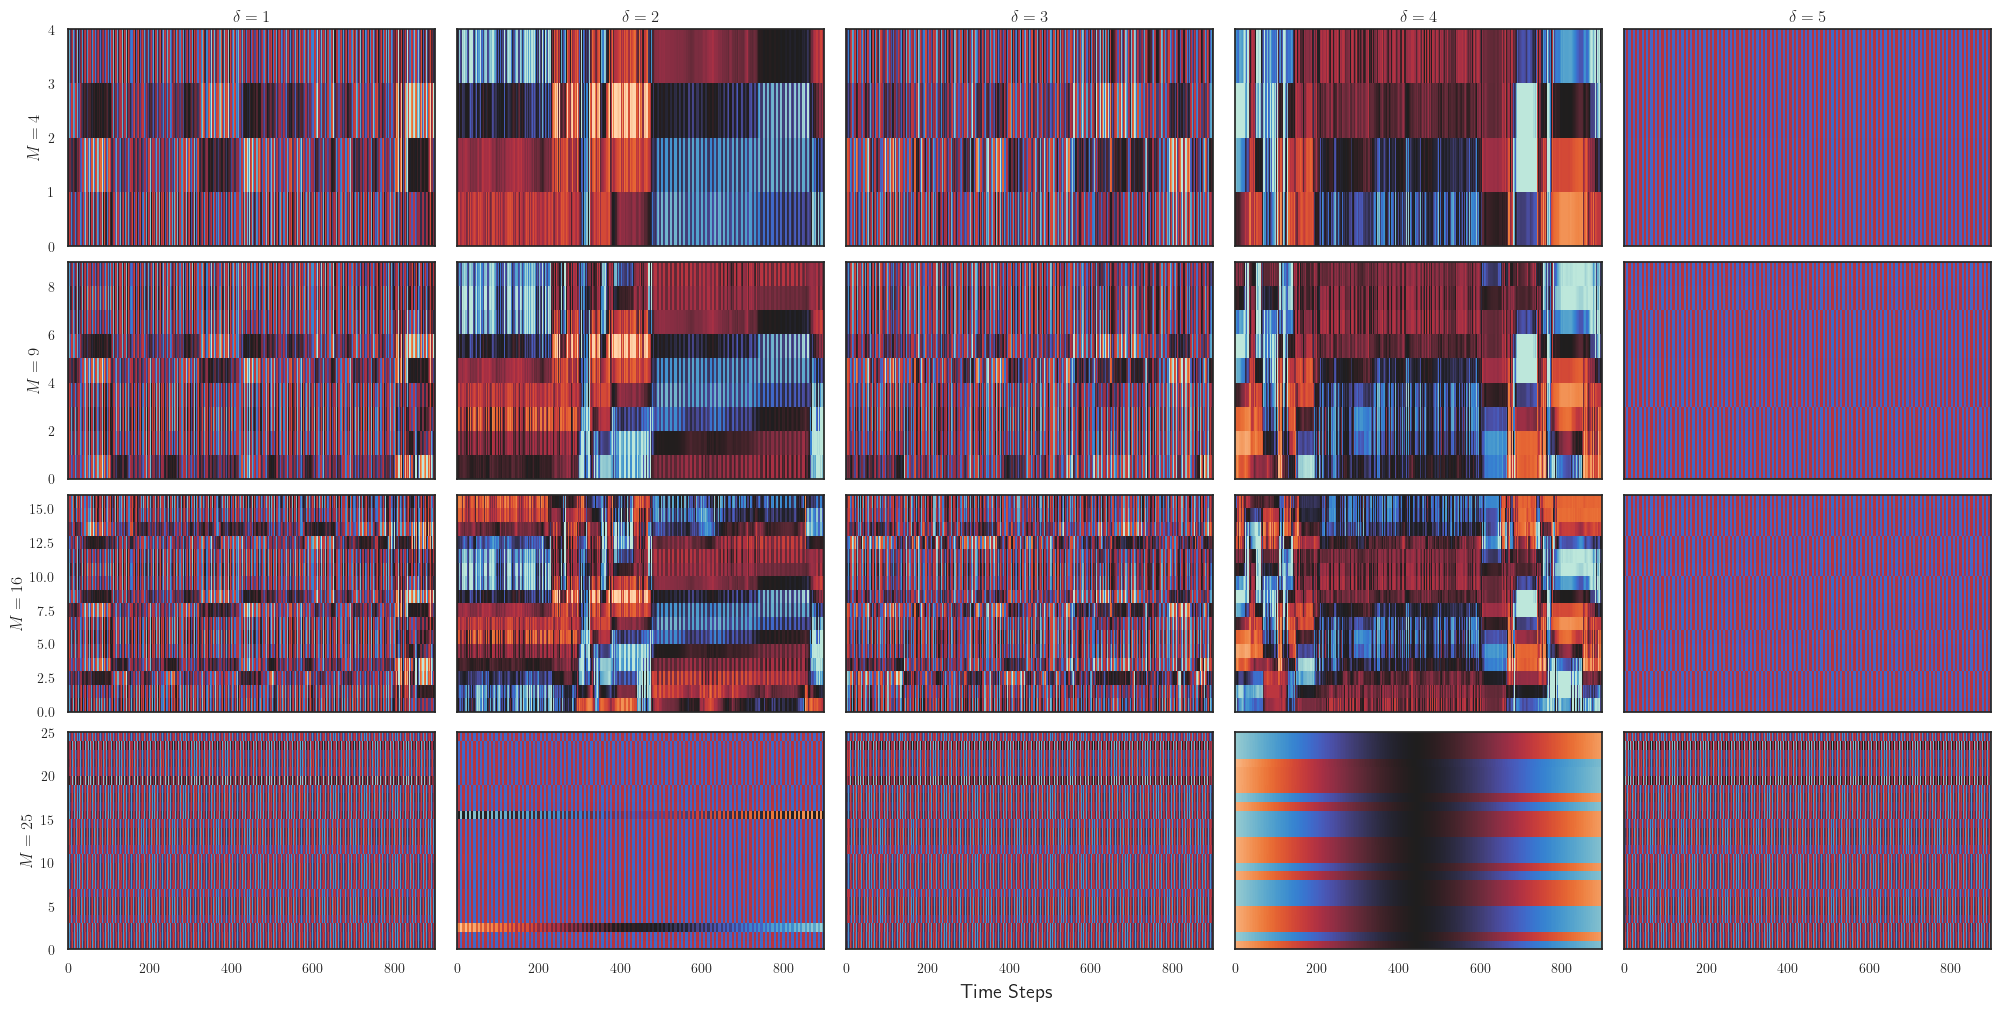

In [217]:
Ms_to_sweep = [4, 9, 16, 25]
deltas_to_sweep = [1,2,3,4,5] # Checking raw vs Period-3 smoothing

grid_data = preview_cml_grid(
    Ms=Ms_to_sweep, 
    deltas=deltas_to_sweep, 
    T=900, 
    seed=5, 
    alpha=1.67, # STI Type I
    eps=0.5, 
    transients=10000,  # STI specific
    respect_transients=True
)



# CML + Kuramoto Toy Demo

Use the project generators to synthesise STI-I CML and Kuramoto datasets, then visualise them with the same heatmap style used in the pipeline.

In [4]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [5]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.generate as gen_mod
importlib.reload(gen_mod)
from src.generate import generate_cml_logistic, generate_kuramoto, generate_wave_1d, generate_wave_2d
from src.plot_style import apply_plot_style

def plot_heatmap(data, title):
    apply_plot_style()
    plt.figure(figsize=(10, 3))
    sns.heatmap(
        data.T,
        cmap=sns.color_palette('icefire', as_cmap=True),
        vmin=-2,
        vmax=2,
        cbar=False,
        xticklabels=False,
        yticklabels=False,
    )
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Channel')
    plt.show()


### Wave-equation parameter sets
Using the Brain Dynamics Toolkit description (wave speed $c=10$, Gaussian initial conditions with $\sigma=M/20$, periodic boundaries), the following combinations reproduce the typical textures:
- $M=9, T=100$ (short checkerboard).
- $M=16, T=500$ (zig-zag reflections).
- $M=25, T=1000$ (dense interference lattice).
We discretise a unit domain with spatial step $\Delta x = 1/M$ and choose $\Delta t = 0.3\Delta x / c$ for stability.

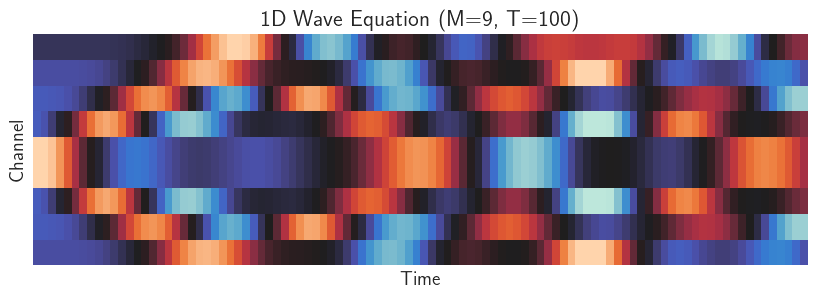

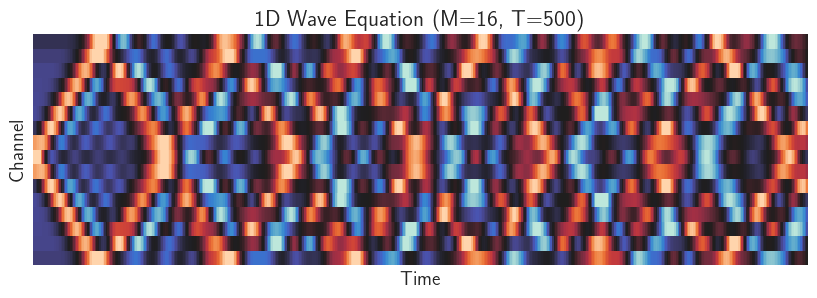

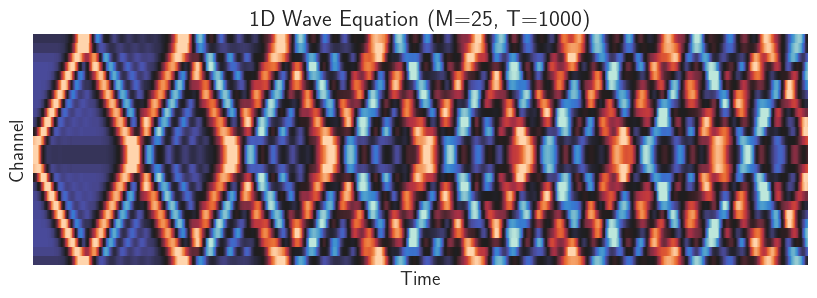

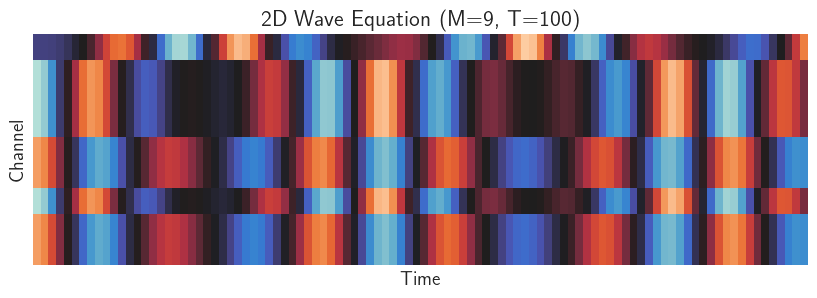

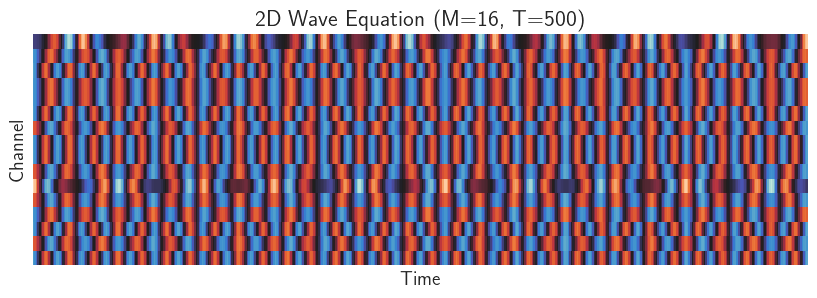

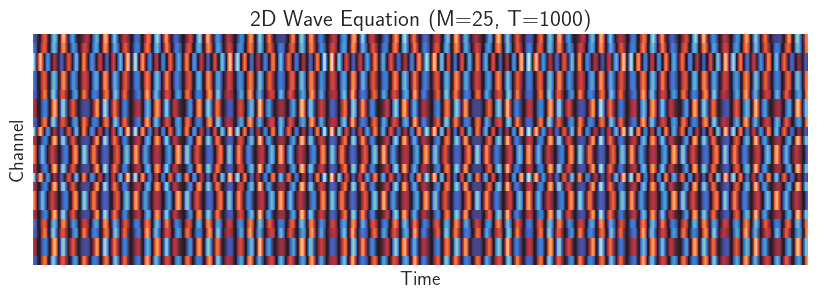

In [6]:
for M, T in [(9, 100), (16, 500), (25, 1000)]:
    wave1d = generate_wave_1d(M=M, T=T)
    plot_heatmap(wave1d, f'1D Wave Equation (M={M}, T={T})')

for M, T in [(9, 100), (16, 500), (25, 1000)]:
    wave2d = generate_wave_2d(M=M, T=T)
    plot_heatmap(wave2d, f'2D Wave Equation (M={M}, T={T})')


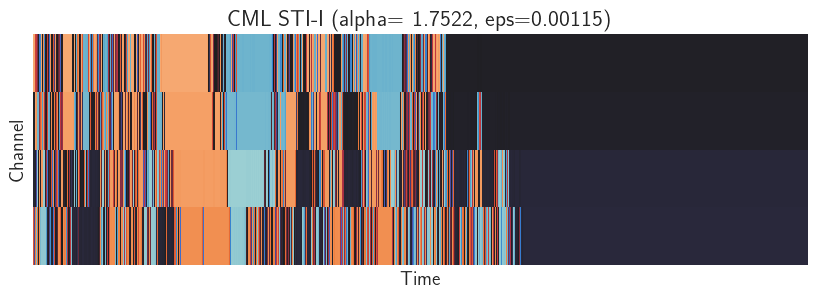

In [9]:
cml_rng = np.random.default_rng(52025)
cml_params = dict(M=4, T=1250, alpha=1.7522, eps=0.00115, delta=12)
cml_data = generate_cml_logistic(rng=cml_rng, **cml_params)
plot_heatmap(cml_data, f"CML STI-I (alpha= {cml_params['alpha']}, eps={cml_params['eps']})")


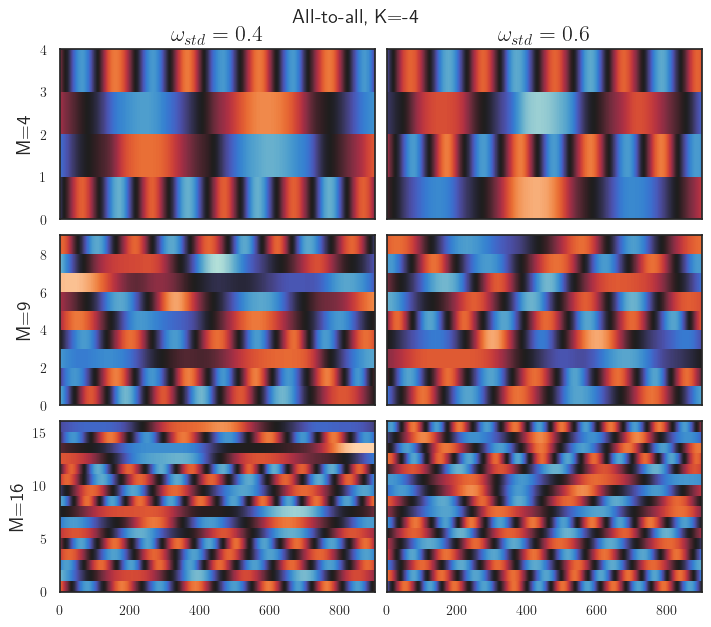

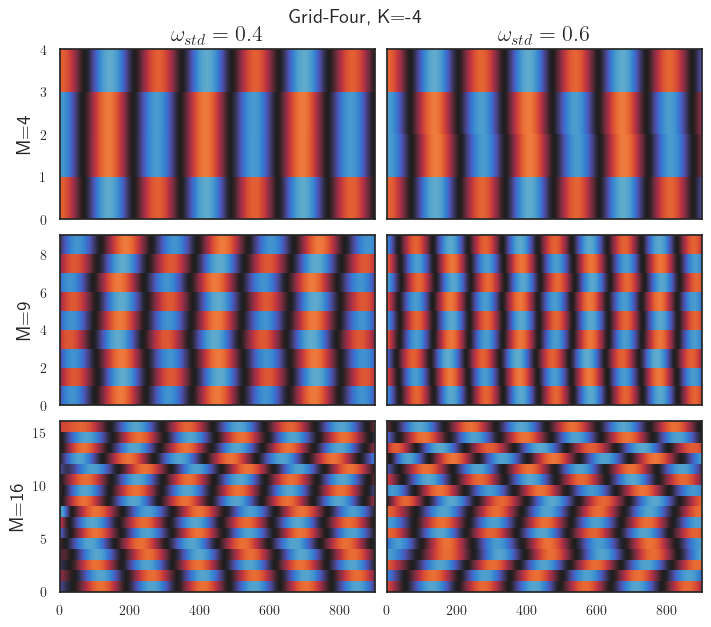

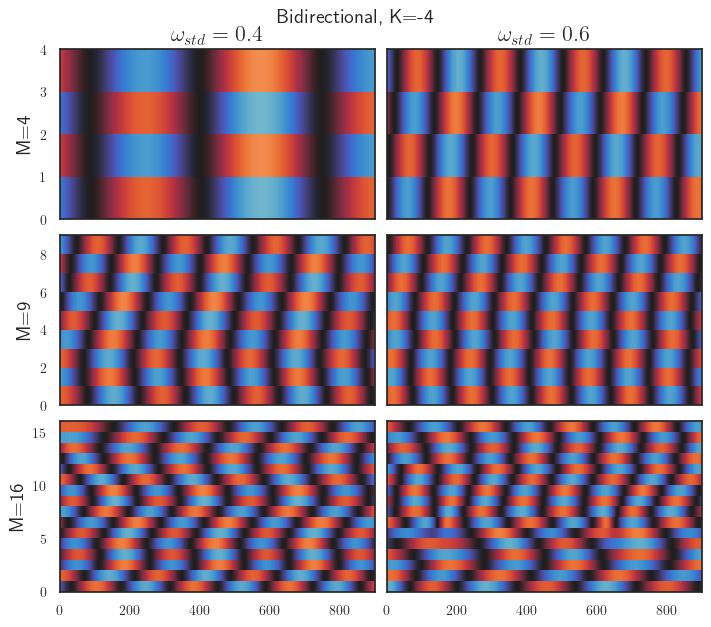

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Sweep Parameters
Ms_sweep = [4, 9, 16]
omega_stds_sweep = [0.4, 0.6]  # Zero spread vs Moderate vs High spread

demo_configs = [
    dict(label="All-to-all, K=-4", kwargs=dict(k=-4, connectivity="all-to-all")),
    dict(label="Grid-Four, K=-4",  kwargs=dict(k=-4, connectivity="grid-four")),
    dict(label="Bidirectional, K=-4", kwargs=dict(k=-4, connectivity="bidirectional-list")),
]

base_kwargs = dict(T=900, dt=0.10, transients=100, eta=0.0)

for cfg in demo_configs:
    n_rows, n_cols = len(Ms_sweep), len(omega_stds_sweep)
    fig, axes = plt.subplots(
        n_rows, n_cols, 
        figsize=(3.5 * n_cols, 2 * n_rows), 
        squeeze=False, sharex='col', constrained_layout=True
    )
    fig.suptitle(cfg['label'], fontweight='bold', y=1.02)

    for i, M in enumerate(Ms_sweep):
        for j, std in enumerate(omega_stds_sweep):
            ax = axes[i, j]
            
            # Reset RNG for valid comparison
            rng = np.random.default_rng(1)
            
            series = generate_kuramoto(
                rng=rng, 
                omega_mean=0.1, 
                omega_std=std,   # Sweeping parameter
                M=M, 
                **base_kwargs, 
                **cfg['kwargs']
            )

            ax.pcolormesh(
                series.T, 
                cmap='icefire', 
                vmin=-2, vmax=2
            )

            if i == 0: ax.set_title(f"$\omega_{{std}}={std}$")
            if j == 0: ax.set_ylabel(f"M={M}")
            
            if i < n_rows - 1: ax.tick_params(labelbottom=False)
            if j > 0: ax.tick_params(labelleft=False)
            
    plt.show()